In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt

In [2]:
tot = pd.read_table("pwscf.pdos_tot", delimiter="\s+")
Fe_d1 = pd.read_table("pwscf.pdos_atm#1(Fe)_wfc#7(d_j1.5)", delimiter="\s+")
Fe_d2 = pd.read_table("pwscf.pdos_atm#1(Fe)_wfc#8(d_j2.5)", delimiter="\s+")
Pt_d1 = pd.read_table("pwscf.pdos_atm#2(Pt)_wfc#4(d_j1.5)", delimiter="\s+")
Pt_d2 = pd.read_table("pwscf.pdos_atm#2(Pt)_wfc#5(d_j2.5)", delimiter="\s+")

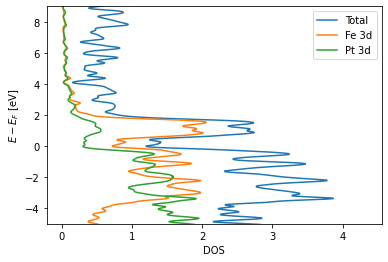

In [3]:
E_F = 16.9627

plt.plot(tot.iloc[:,1], tot.iloc[:,0] - E_F, label="Total")
plt.plot(Fe_d1.iloc[:,1] + Fe_d2.iloc[:,1], Fe_d1.iloc[:,0] - E_F, label="Fe 3d")
plt.plot(Pt_d1.iloc[:,1] + Pt_d2.iloc[:,1], Pt_d1.iloc[:,0] - E_F, label="Pt 3d")


plt.ylim(-5, 9)
plt.xlabel("DOS")
plt.ylabel("$E - E_F$ [eV]")
plt.legend()
plt.savefig("dos.pdf")
plt.show()

In [4]:
from scipy import stats
import sys
import toml
from pathlib import Path
sys.path.append("../../../../../src")
from mag_rotation import MagRotation
from ma_quantities import MaQuantities
from wannier_utils.hamiltonian import HamK

class Dos:
    def __init__(self, mae, ylim=[-5,5], spin_axis="x"):
        self.E_F = 16.9627
        self.klen = mae.klen
        
        self._spin_orbital_projection(mae, spin_axis)
        self._calc_pdos(mae)

    def _spin_orbital_projection(self, mae, spin_axis="x"):
        self.spin_orbit_projection = np.zeros([int(mae.num_wann/2), len(mae.sorted_energy)])
        Sx,Sy,Sz = np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]])
        for ik in range(len(mae.sorted_energy)):
            tmp = mae.sorted_eigvec[:,ik].reshape(int(mae.num_wann/2), 2)
            if spin_axis == "x":
                self.spin_orbit_projection[:,ik] = np.einsum("ij,jk,ik -> i", np.conjugate(tmp), Sx, tmp).real
            if spin_axis == "z":
                self.spin_orbit_projection[:,ik] = np.einsum("ij,jk,ik -> i", np.conjugate(tmp), Sz, tmp).real

    def _calc_pdos(self, mae, smearing=0.08):
        shifted_energy = mae.sorted_energy - self.E_F
        self.energy_window = np.linspace(min(shifted_energy), max(shifted_energy), len(shifted_energy))
        self.spin_up_pdos = np.zeros([int(mae.num_wann/2), len(shifted_energy)])
        self.spin_down_pdos = np.zeros([int(mae.num_wann/2), len(shifted_energy)])

        for ik,en in enumerate(shifted_energy):
            for orb in range(int(mae.num_wann/2)):
                if self.spin_orbit_projection[orb,ik] >= 0:
                    self.spin_up_pdos[orb,:] += stats.norm.pdf(self.energy_window, loc=en, scale=0.08) * self.spin_orbit_projection[orb,ik]
                else:
                    self.spin_down_pdos[orb,:] += stats.norm.pdf(self.energy_window, loc=en, scale=0.08) * self.spin_orbit_projection[orb,ik]
        self.spin_up_pdos, self.spin_down_pdos = self.spin_up_pdos / self.klen, self.spin_down_pdos / self.klen
  

In [5]:
with open("../../../input_params.toml") as f:
    params = toml.load(f)

ham = MagRotation( 
        tb_dat=Path(params["tb_dat"]), 
        extract_only_x_component=int(params["extract_only_x_component"]),
        use_convert_ham_r=int(params["use_convert_ham_r"]),
        nnkp_file=Path(params["nnkp_file"]),
        win_file=Path(params["win_file"]),
    )

2023-09-15 19:00:35,366 [wannier_utils.hamiltonian INFO]: Reading /home/hirotosaito/MaterialsProject/mag20230526/MAE_programs/tests/mp-2260/pwscf_rel_sym/mae/wan/pwscf_py_tb.dat ...
2023-09-15 19:00:37,941 [wannier_utils.hamiltonian INFO]: Reading /home/hirotosaito/MaterialsProject/mag20230526/MAE_programs/tests/mp-2260/pwscf_rel_sym/mae/wan/pwscf_py_tb.dat is Done.
2023-09-15 19:00:37,942 [wannier_utils.hamiltonian DEBUG]: Wannier center from Amnrs:
2023-09-15 19:00:37,942 [wannier_utils.hamiltonian DEBUG]:   0      0.00000000     -0.00000000     -0.00000000
2023-09-15 19:00:37,942 [wannier_utils.hamiltonian DEBUG]:   1     -0.00000000      0.00000000     -0.00000000
2023-09-15 19:00:37,942 [wannier_utils.hamiltonian DEBUG]:   2     -0.00000000     -0.00000000     -0.00000000
2023-09-15 19:00:37,943 [wannier_utils.hamiltonian DEBUG]:   3      0.00000000      0.00000000      0.00000000
2023-09-15 19:00:37,943 [wannier_utils.hamiltonian DEBUG]:   4      0.00000000     -0.00000000      0

In [6]:
mae = MaQuantities(ham, 
                   params["num_valence"],
                   win_file=Path(params["win_file"]),
                   calc_spin_angular_momentum=True)


In [7]:
dos = Dos(mae)

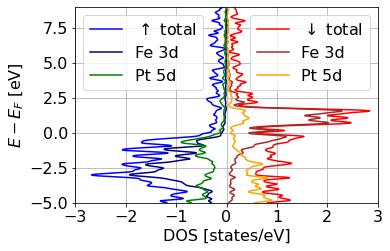

In [9]:
plt.figure()
plt.rcParams["font.size"] = 16
plt.rcParams['figure.subplot.left'] = 0.20
plt.rcParams['figure.subplot.bottom'] = 0.20
p1, = plt.plot(np.einsum("ij->j", dos.spin_up_pdos), dos.energy_window, color="red", label="$\downarrow$ total")
p2, = plt.plot(np.einsum("ij->j", dos.spin_down_pdos), dos.energy_window, color="blue", label="$\\uparrow$ total")

#p3, = plt.plot(np.einsum("ij->j", dos.spin_up_pdos[1:4,:]), dos.energy_window, color="orange", label="Fe 2p")
#p4, = plt.plot(np.einsum("ij->j", dos.spin_down_pdos[1:4,:]), dos.energy_window, color="cyan", label="Fe 2p")
p5, = plt.plot(np.einsum("ij->j", dos.spin_up_pdos[4:9,:]), dos.energy_window, color="brown", label="Fe 3d")
p6, = plt.plot(np.einsum("ij->j", dos.spin_down_pdos[4:9,:]), dos.energy_window, color="navy", label="Fe 3d")

#p7, = plt.plot(np.einsum("ij->j", dos.spin_up_pdos[9:12,:]), dos.energy_window, color="orange", label="Pt 4p")
#p8, = plt.plot(np.einsum("ij->j", dos.spin_down_pdos[9:12,:]), dos.energy_window, color="cyan", label="Pt 4p")
p9, = plt.plot(np.einsum("ij->j", dos.spin_up_pdos[12:17,:]), dos.energy_window, color="orange", label="Pt 5d")
p10, = plt.plot(np.einsum("ij->j", dos.spin_down_pdos[12:17,:]), dos.energy_window, color="green", label="Pt 5d")

legend_up = plt.legend(handles=[p1,p5,p9], loc='upper right')
ax = plt.gca().add_artist(legend_up)
plt.legend(handles=[p2,p6,p10], loc='upper left')

plt.xlim(-3,3)
plt.ylim(-5, 9)

plt.grid()
plt.xlabel("DOS [states/eV]")
plt.ylabel("$E - E_F$ [eV]")
plt.savefig("dos_wan.pdf")
plt.show()